# Top 10 Best Selling Products by Sales Value

This notebook demonstrates how to identify the highest-performing products in the Complete Journey dataset based on total sales value.

## Setup and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from completejourney_py import get_data

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the required datasets
data = get_data(["transactions", "products"])
transactions = data["transactions"]
products = data["products"]

print(f"Loaded {len(transactions):,} transaction records")
print(f"Loaded {len(products):,} product records")

Loaded 1,469,307 transaction records
Loaded 92,331 product records


## Analysis: Top Products by Sales Value

In [3]:
# Calculate total sales value by product
product_sales = (
    transactions
    .groupby('product_id')['sales_value']
    .agg(['sum', 'count', 'mean'])
    .reset_index()
    .rename(columns={'sum': 'total_sales', 'count': 'total_transactions', 'mean': 'avg_transaction_value'})
)

# Sort by total sales and get top 10
top_products = product_sales.nlargest(10, 'total_sales')

print("Top 10 Products by Total Sales Value:")
print(top_products[['product_id', 'total_sales', 'total_transactions']].round(2))

Top 10 Products by Total Sales Value:
       product_id  total_sales  total_transactions
42369     6534178    303116.02               11582
42340     6533889     27467.61                 823
23098     1029743     22729.71                7874
42365     6534166     20477.54                 722
42333     6533765     19451.66                1150
27971     1082185     17219.59               16992
12526      916122     16120.01                2497
30193     1106523     15629.95                5424
19879      995242     15602.59                7441
39480     5569230     13410.46                2771


## Enriching with Product Information

In [4]:
# Join with product information to get descriptions
top_products_detailed = top_products.merge(
    products[['product_id', 'product_category', 'brand', 'department', 'product_type']],
    on='product_id',
    how='left'
)

# Display detailed results
print("Top 10 Products with Details:")
print("=" * 80)

for i, row in top_products_detailed.iterrows():
    print(f"{i+1:2d}. ${row['total_sales']:>8,.0f} - {row['product_category']}: {row['product_type']} ({row['brand']})")
    print(f"    Department: {row['department']} | Transactions: {row['total_transactions']:,}")
    print(f"    Avg Transaction Value: ${row['avg_transaction_value']:.2f}")
    print()

Top 10 Products with Details:
 1. $ 303,116 - COUPON/MISC ITEMS: GASOLINE-REG UNLEADED (Private)
    Department: FUEL | Transactions: 11,582
    Avg Transaction Value: $26.17

 2. $  27,468 - COUPON/MISC ITEMS: GASOLINE-REG UNLEADED (Private)
    Department: MISCELLANEOUS | Transactions: 823
    Avg Transaction Value: $33.37

 3. $  22,730 - FLUID MILK PRODUCTS: FLUID MILK WHITE ONLY (Private)
    Department: GROCERY | Transactions: 7,874
    Avg Transaction Value: $2.89

 4. $  20,478 - COUPON/MISC ITEMS: GASOLINE-REG UNLEADED (Private)
    Department: MISCELLANEOUS | Transactions: 722
    Avg Transaction Value: $28.36

 5. $  19,452 - FUEL: GASOLINE-REG UNLEADED (Private)
    Department: FUEL | Transactions: 1,150
    Avg Transaction Value: $16.91

 6. $  17,220 - TROPICAL FRUIT: BANANAS (National)
    Department: PRODUCE | Transactions: 16,992
    Avg Transaction Value: $1.01

 7. $  16,120 - CHICKEN: CHICKEN BREAST BONELESS (National)
    Department: MEAT | Transactions: 2,497
    

## Visualization

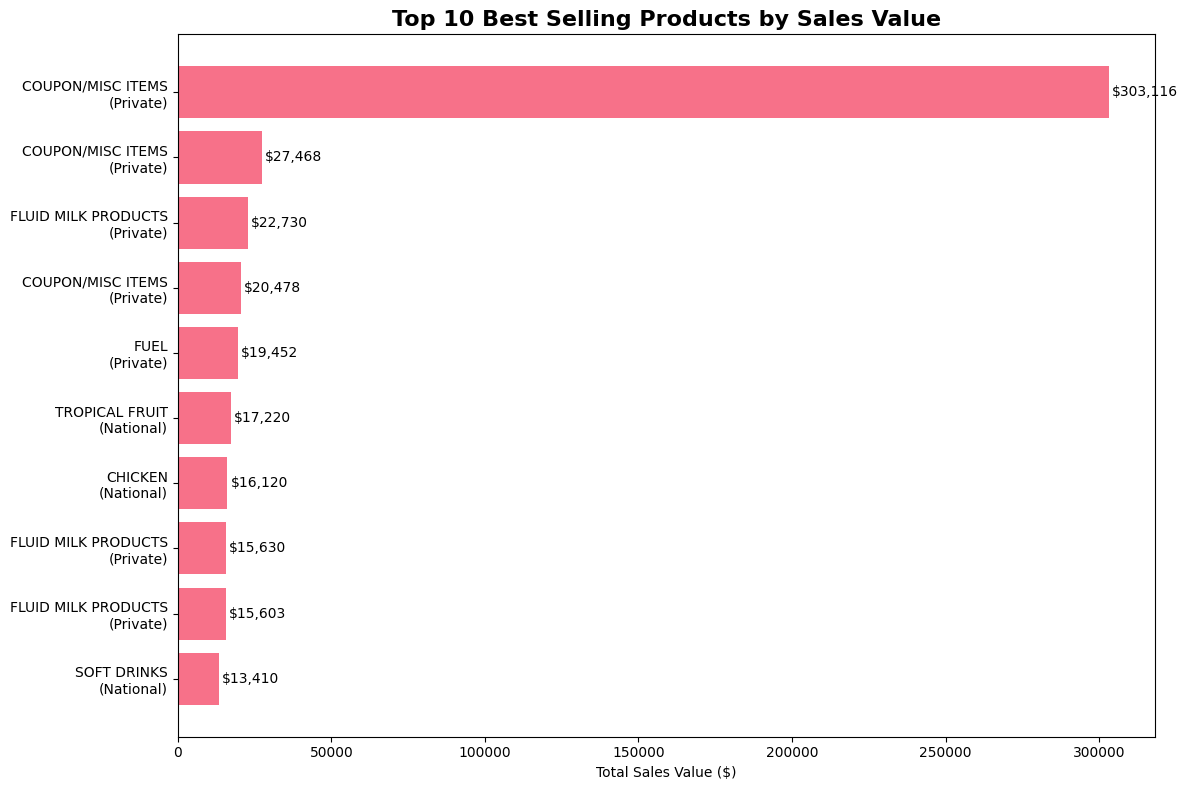

In [5]:
# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Create labels combining product category and brand
labels = [f"{row['product_category']}\n({row['brand']})" for _, row in top_products_detailed.iterrows()]

# Create horizontal bar chart
bars = ax.barh(range(len(top_products_detailed)), top_products_detailed['total_sales'])

# Customize the chart
ax.set_yticks(range(len(top_products_detailed)))
ax.set_yticklabels(labels)
ax.set_xlabel('Total Sales Value ($)')
ax.set_title('Top 10 Best Selling Products by Sales Value', fontsize=16, fontweight='bold')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 1000, bar.get_y() + bar.get_height()/2, 
            f'${width:,.0f}', ha='left', va='center')

# Invert y-axis to show highest values at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()

## Analysis by Department

In [6]:
# Analyze top products by department
dept_analysis = (
    top_products_detailed
    .groupby('department')
    .agg({
        'total_sales': ['sum', 'count'],
        'total_transactions': 'sum'
    })
    .round(2)
)

dept_analysis.columns = ['Total_Sales', 'Product_Count', 'Total_Transactions']
dept_analysis = dept_analysis.sort_values('Total_Sales', ascending=False)

print("Top Products by Department:")
print(dept_analysis)

Top Products by Department:
               Total_Sales  Product_Count  Total_Transactions
department                                                   
FUEL             322567.68              2               12732
GROCERY           67372.71              4               23510
MISCELLANEOUS     47945.15              2                1545
PRODUCE           17219.59              1               16992
MEAT              16120.01              1                2497


## Aggregated Product Perspective

Looking at the top 10 individual products, we notice several patterns emerge. Many of the highest-selling products represent similar product categories such as fuel, coupons, and milk products. This suggests that while individual products vary, certain **product types** dominate sales performance.

Let's aggregate sales by product type to identify which categories drive the most revenue overall.

In [7]:
# Aggregate sales by product type
product_type_sales = (
    transactions
    .merge(products[['product_id', 'product_type', 'product_category', 'department']], on='product_id')
    .groupby(['product_type', 'product_category', 'department'])
    .agg({
        'sales_value': 'sum',
        'product_id': 'nunique',  # Count unique products
        'household_id': 'nunique'  # Count unique customers
    })
    .reset_index()
    .rename(columns={
        'sales_value': 'total_sales',
        'product_id': 'unique_products',
        'household_id': 'unique_customers'
    })
    .sort_values('total_sales', ascending=False)
)

# Get top 15 product types
top_product_types = product_type_sales.head(15)

print("Top 15 Product Types by Total Sales Value:")
print("=" * 90)

n = 0
for i, row in top_product_types.iterrows():
    n += 1
    print(f"{n}: ${row['total_sales']:>3,.0f} - {row['product_type']}")
    print(f"   Category: {row['product_category']} | Department: {row['department']}")
    print(f"   {row['unique_products']} unique products | {row['unique_customers']:,} customers")
    print()

Top 15 Product Types by Total Sales Value:
1: $309,668 - GASOLINE-REG UNLEADED
   Category: COUPON/MISC ITEMS | Department: FUEL
   9 unique products | 1,124 customers

2: $91,834 - FLUID MILK WHITE ONLY
   Category: FLUID MILK PRODUCTS | Department: GROCERY
   148 unique products | 2,214 customers

3: $89,597 - SOFT DRINKS 12/18&15PK CAN CAR
   Category: SOFT DRINKS | Department: GROCERY
   308 unique products | 1,783 customers

4: $81,266 - BEERALEMALT LIQUORS
   Category: BEERS/ALES | Department: GROCERY
   614 unique products | 1,287 customers

5: $54,450 - GASOLINE-REG UNLEADED
   Category: COUPON/MISC ITEMS | Department: MISCELLANEOUS
   14 unique products | 212 customers

6: $54,350 - CIGARETTES
   Category: CIGARETTES | Department: DRUG GM
   301 unique products | 782 customers

7: $45,684 - CHOICE BEEF
   Category: BEEF | Department: MEAT
   214 unique products | 1,318 customers

8: $38,214 - SHREDDED CHEESE
   Category: CHEESE | Department: GROCERY
   208 unique products | 1,

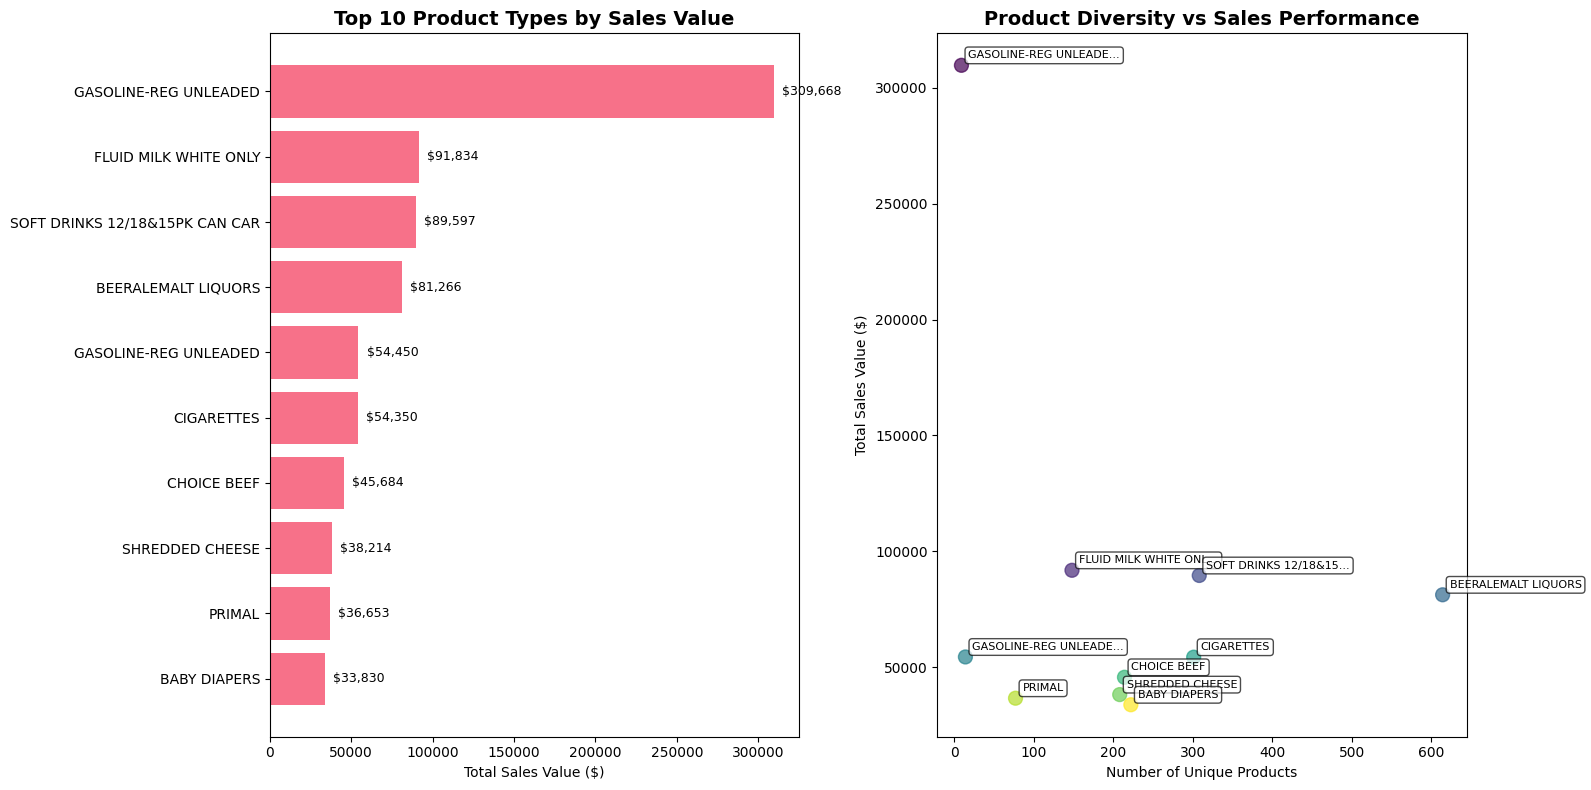

In [8]:
# Visualize top product types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Chart 1: Top 10 Product Types by Sales Value
top_10_types = top_product_types.head(10)
bars1 = ax1.barh(range(len(top_10_types)), top_10_types['total_sales'])
ax1.set_yticks(range(len(top_10_types)))
ax1.set_yticklabels([f"{row['product_type']}" for _, row in top_10_types.iterrows()])
ax1.set_xlabel('Total Sales Value ($)')
ax1.set_title('Top 10 Product Types by Sales Value', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# Add value labels
for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 5000, bar.get_y() + bar.get_height()/2, 
            f'${width:,.0f}', ha='left', va='center', fontsize=9)

# Chart 2: Product Diversity vs Sales Performance
ax2.scatter(top_10_types['unique_products'], top_10_types['total_sales'], 
           s=100, alpha=0.7, c=range(len(top_10_types)), cmap='viridis')

# Annotate points with product type names
for i, row in top_10_types.iterrows():
    ax2.annotate(row['product_type'][:20] + ('...' if len(row['product_type']) > 20 else ''), 
                (row['unique_products'], row['total_sales']),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax2.set_xlabel('Number of Unique Products')
ax2.set_ylabel('Total Sales Value ($)')
ax2.set_title('Product Diversity vs Sales Performance', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Key Insights from Product Type Analysis

The aggregated perspective reveals several important patterns:

**1. Fuel Dominance**: Gasoline products represent the highest sales volume, confirming that fuel is a major revenue driver for the business.

**2. Essential Categories**: The top product types include everyday necessities:
   - **Gasoline** (fuel/convenience)
   - **Milk products** (grocery staples) 
   - **Bananas** (fresh produce)
   - **Bread** (pantry essentials)

**3. Product Concentration vs. Diversity**:
   - Some categories achieve high sales with **few product variations** (e.g., gasoline)
   - Others succeed through **product diversity** with many SKUs contributing smaller amounts
   - The scatter plot shows the relationship between product variety and total sales

**4. Cross-Category Performance**:
   - **FUEL department** leads in total sales value
   - **GROCERY department** shows strong performance across multiple product types
   - **PRODUCE department** achieves significant sales with high-volume, low-margin items

**5. Customer Reach**: 
   - Essential items like milk and bananas reach the most households
   - Specialty items may have high per-transaction value but limited customer base

This aggregated view helps identify which **product categories** to prioritize for:
- Inventory management and supplier relationships
- Promotional strategies and pricing optimization  
- Store layout and merchandising decisions
- Category expansion opportunities

## Next Steps

Consider extending this analysis by:
- Examining seasonal trends for top products
- Analyzing customer segments purchasing these products
- Investigating price elasticity and promotional responsiveness
- Comparing performance across different store locations